# EIIE for Portfolio Management on DJ30
This tutorial is to demonstrate an example of using EIIE to do portfolio management on DJ30
## Set up Experinment Environment

In [1]:
from IPython.display import clear_output
import argparse
import sys
import numpy as np
import torch
from torch import nn
import yaml
import os
import pandas as pd
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)
requirements_path=module_path+"/requirements.txt"
print(requirements_path)
command="pip install -r "+requirements_path
os.system(command)
clear_output(wait=True)
! conda install pytorch torchvision torchaudio cudatoolkit=11.3 -c pytorch
clear_output(wait=True)

failed

CondaError: KeyboardInterrupt



## Download and Preprocess the Data
The dataconfig part in TradeMaster is shared by all other parts, it is worth noticing that for algorithms trading, only the dataset BTC is supported.

The following code will help to download the data in the folder [.data/data/dj30](https://github.com/qinmoelei/TradeMaster_reframe/tree/master/tutorial/data/data/dj30), where 4 files could be found: the whole data and train, valid and test data which will be used when we try to construct the RL environment for the agent

In [2]:
from data.download_data import Dataconfig
parser = argparse.ArgumentParser()

parser.add_argument("--data_path",
                    type=str,
                    default="./data/data/",
                    help="the path for storing the downloaded data")
#where we store the dataset
parser.add_argument(
    "--output_config_path",
    type=str,
    default="./config/output_config/data",
    help="the path for storing the generated config file for data")
# where we store the config file
parser.add_argument(
    "--dataset",
    choices=["exchange","dj30","sz50","crypto"],
    default="dj30",
    help="the name of the dataset",
)
parser.add_argument("--split_proportion",
                    type=list,
                    default=[0.8, 0.1, 0.1],
                    help="the split proportion for train, valid and test")
parser.add_argument(
    "--generate_config",
    type=bool,
    default=False,
    help=
    "determine whether to generate a yaml file to memorize the train valid and test'data's dict"
)
parser.add_argument(
    "--input_config",
    type=bool,
    default=False,
    help=
    "determine whether to use a yaml file as the overall input of the Dataconfig, this is needed when have other format of dataset"
)

parser.add_argument(
    "--input_config_path",
    type=str,
    default="config/input_config/data/custom.yml",
    help=
    "determine the location of a yaml file used to initialize the Dataconfig Class"
)
args = parser.parse_args(args=[])
a = Dataconfig(args)
clear_output(wait=True)
clear_output(wait=True)

/home/sunshuo/qml/TradeMaster/data/preprocess.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  (temp_indicator.close.rolling(2).sum() - temp_indicator.close)) - 1
/home/sunshuo/qml/TradeMaster/data/preprocess.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  5) / temp_indicator.adjcp - 1
/home/sunshuo/qml/TradeMaster/data/preprocess.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

The preprocessed data follows the following structure:


In [3]:
data=pd.read_csv("data/data/dj30/dj30.csv",index_col=0)
data.head(5)

,date,open,high,low,close,adjcp,tic,zopen,zhigh,zlow,zadjcp,zclose,zd_5,zd_10,zd_15,zd_20,zd_25,zd_30
0,2012-01-03,14.621429,14.732143,14.607143,14.686786,12.575916,AAPL,-0.004450,0.003088,-0.005423,-0.143726,0.005374,-0.010348,-0.011415,0.002751,-0.061124,-0.072128,-0.126481
1,2012-01-04,14.642857,14.810000,14.617143,14.765714,12.643501,AAPL,-0.008320,0.002999,-0.010062,-0.143726,0.005374,-0.010348,-0.011415,0.002751,-0.061124,-0.072128,-0.126481
2,2012-01-05,14.819643,14.948214,14.738214,14.929643,12.783867,AAPL,-0.007368,0.001244,-0.012822,-0.143726,0.011102,-0.010348,-0.011415,0.002751,-0.061124,-0.072128,-0.126481
3,2012-01-06,14.991786,15.098214,14.972143,15.085714,12.917509,AAPL,-0.006226,0.000829,-0.007528,-0.143726,0.010454,-0.010348,-0.011415,0.002751,-0.061124,-0.072128,-0.126481
4,2012-01-09,15.196429,15.276786,15.048214,15.061786,12.897021,AAPL,0.008939,0.014275,-0.000901,-0.143726,-0.001586,-0.010348,-0.011415,0.002751,-0.061124,-0.072128,-0.126481


## EIIE Enviornment Construction, Agent Training, Model Picking and Testing
For the simplicity, we use the yaml file to store the configuration for the RL environment construction, which can be found [here](https://github.com/qinmoelei/TradeMaster_reframe/tree/master/tutorial/config/input_config/env/PM/portfolio_for_EIIE)
but first, let us import the package we might use

In [5]:
from agent.EIIE.trader import trader
from agent.EIIE.util import *
from env.PM.portfolio_for_EIIE import Tradingenv
from agent.EIIE.model import EIIE_con, EIIE_lstm, EIIE_rnn, EIIE_critirc
parser = argparse.ArgumentParser()
parser.add_argument("--random_seed",
                    type=int,
                    default=12345,
                    help="the path for storing the downloaded data")
parser.add_argument(
    "--env_config_path",
    type=str,
    default="config/input_config/env/portfolio/portfolio_for_EIIE/",
    help="the path for storing the downloaded data")
parser.add_argument(
    "--net_type",
    choices=["conv", "lstm", "rnn"],
    default="conv",
    help="the name of the model",
)
parser.add_argument(
    "--num_hidden_nodes",
    type=int,
    default=32,
    help="the number of hidden nodes in lstm or rnn",
)
parser.add_argument(
    "--num_out_channel",
    type=int,
    default=2,
    help="the number of channel",
)
parser.add_argument(
    "--gamma",
    type=float,
    default=0.99,
    help="the gamma for DPG",
)
parser.add_argument(
    "--model_path",
    type=str,
    default="result/PM/EIIE/trained_model",
    help="the path for trained model",
)
parser.add_argument(
    "--result_path",
    type=str,
    default="result/PM/EIIE/test_result",
    help="the path for test result",
)
parser.add_argument(
    "--num_epoch",
    type=int,
    default=2,
    help="the number of epoch we train",
)
args = parser.parse_args(args=[])
with torch.autograd.set_detect_anomaly(True):
    a = trader(args)
    a.train_with_valid()
    a.test()
clear_output(wait=True)

KeyboardInterrupt: 

Test Visualization

In [5]:
import pandas as pd
test_result=pd.read_csv("result/PM/EIIE/test_result/result.csv",index_col=0)
test_result.head(5)

,daily_return,total assets
0,0.000000,100000.000000
1,0.003422,100342.177295
2,0.007735,101118.368687
3,-0.000197,101098.406522
4,-0.007962,100293.477948


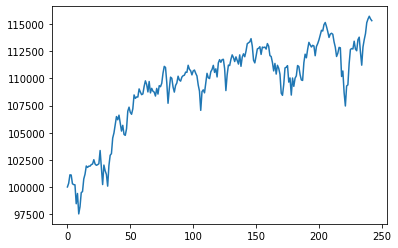

In [4]:
from matplotlib import pyplot as plt
x = range(len(test_result))
y = test_result["total assets"].tolist()
plt.plot(x, y)  
plt.show()